2024-07-16 19:08:33,925 - INFO - {'current_charge': 0.0, 'capacity': 300, 'charging_power_limit': 75, 'discharging_power_limit': -75, 'charging_efficiency': 0.95, 'discharging_efficiency': 0.95, 'min_depth_of_discharge': 150.0, 'max_depth_of_discharge': 291.0}
2024-07-16 19:08:33,953 - INFO - Loaded data from ./input_data/BESS_Input.csv
2024-07-16 19:08:34,000 - INFO - Running optimization from  01/01/23 2023 00:00  to  01/31/23 2023 23:30 
2024-07-16 19:08:37,828 - INFO - Time elapsed for optimization: 3.3276398181915283 seconds
2024-07-16 19:08:37,838 - INFO - Cost without battery for January 2023: £49930
2024-07-16 19:08:37,838 - INFO - Cost with battery for January 2023: £49560
2024-07-16 19:08:37,838 - INFO - Score for January 2023: -0.7410%
2024-07-16 19:08:37,842 - INFO - Money saved/earned for January 2023: £370
2024-07-16 19:08:37,842 - INFO - Running optimization from  02/01/23 2023 00:00  to  02/28/23 2023 23:30 
2024-07-16 19:08:41,061 - INFO - Time elapsed for optimization

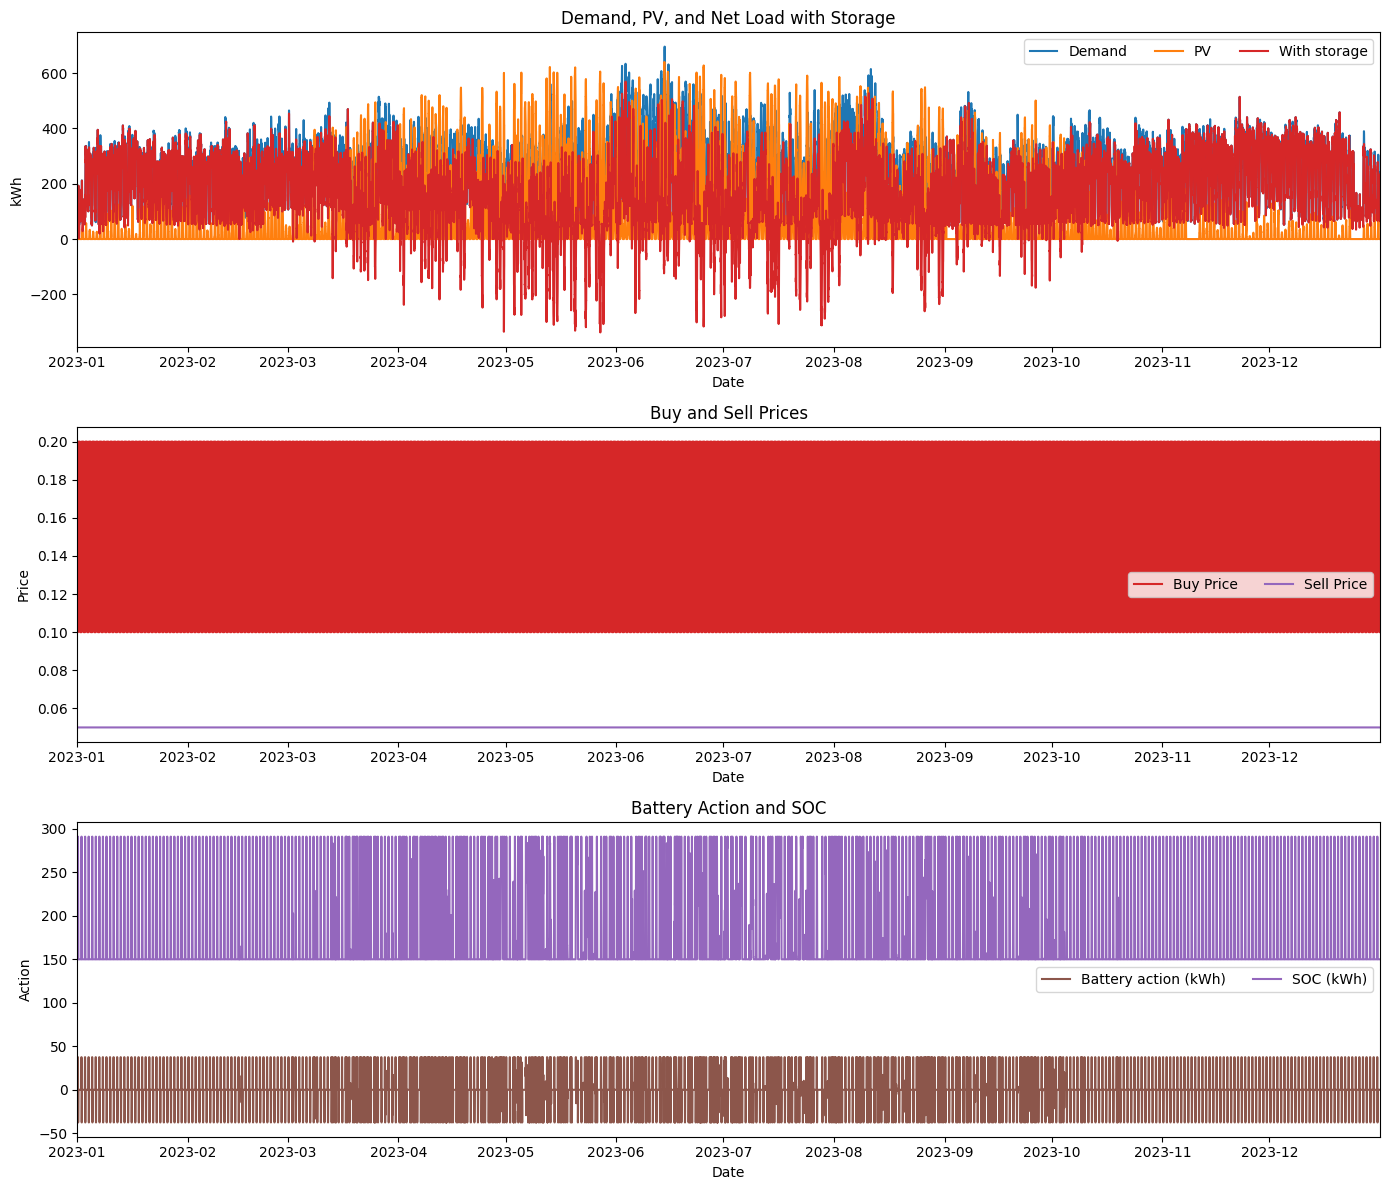

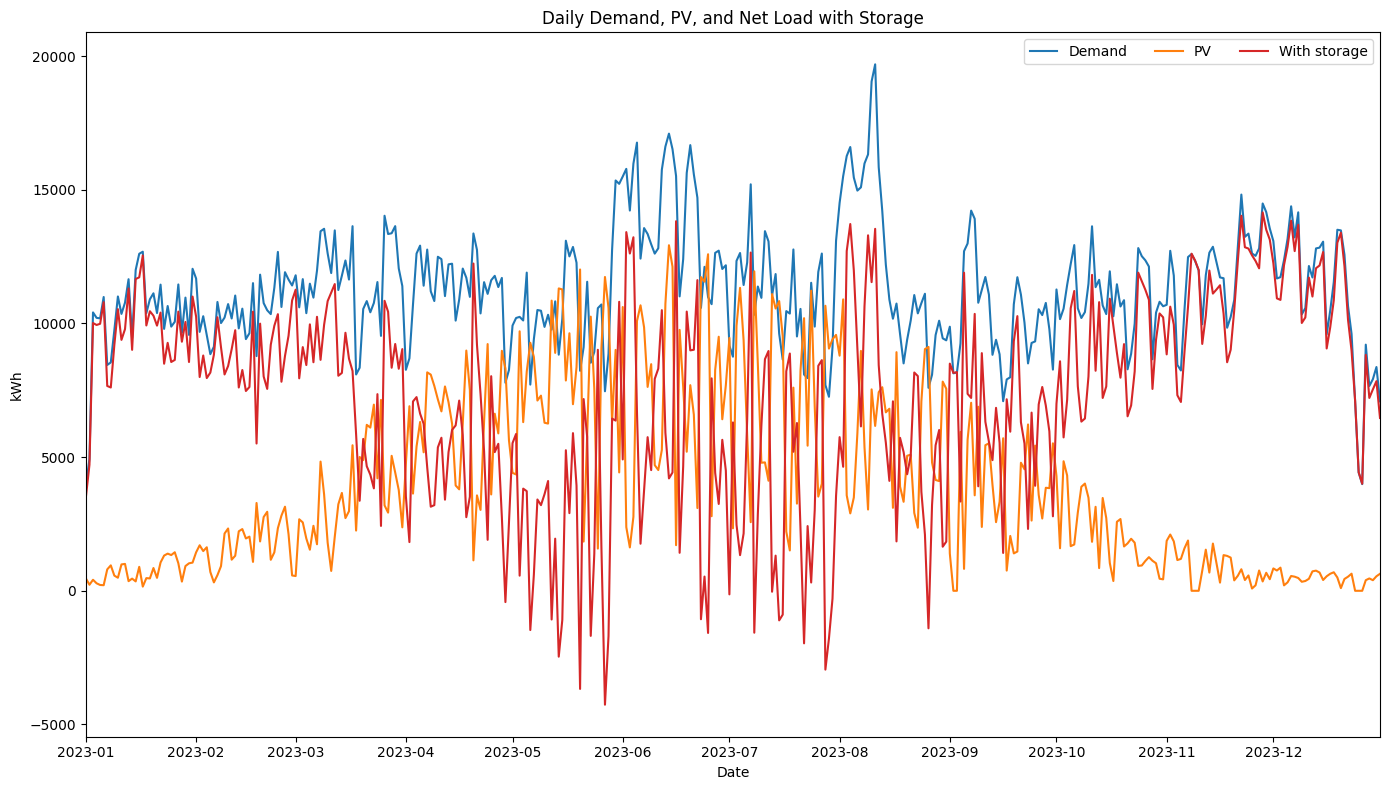

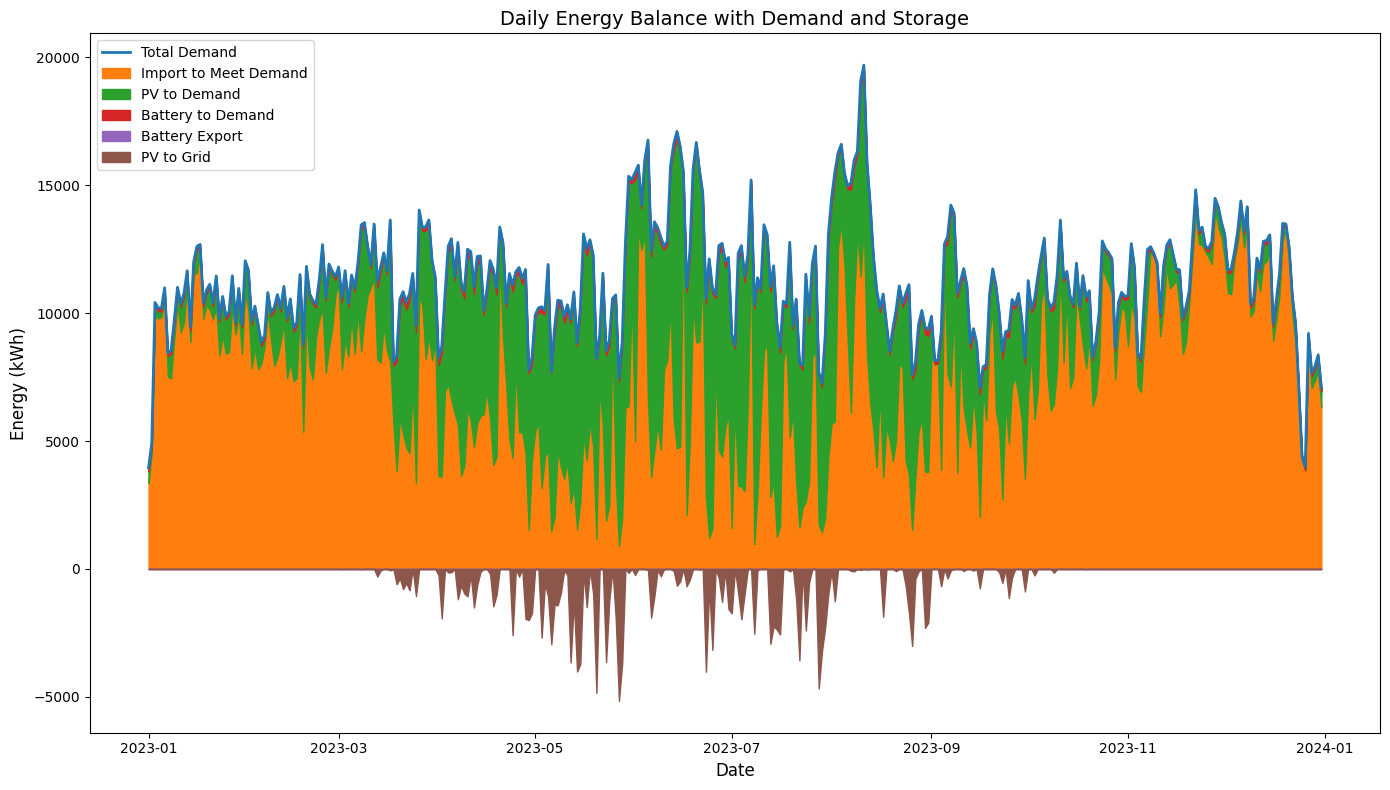

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyomo.environ as en
from pyomo.opt import SolverFactory
from assests.battery import Battery
import time
import logging

# Set up seaborn style
sns.set_style({
    'axes.linewidth': 1, 'axes.edgecolor': 'black',
    'xtick.direction': 'out', 'xtick.major.size': 4.0,
    'ytick.direction': 'out', 'ytick.major.size': 4.0,
    'axes.facecolor': 'white', 'grid.color': '.8',
    'grid.linestyle': '-', 'grid.linewidth': 0.5
})

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
TIME_STEP_HOURS = 0.5
BIG_M = 500000

# Battery Parameters
Bcapacity = 300  # kWh
Bcharging_power = 75  # kW
Bdischarging_power = -75  # kW
Bcharging_efficiency = 0.95
Bdischarging_efficiency = 0.95
Bmin_soc = 0.5
Bmax_soc = 0.97
Binitial_soc = Bcapacity * Bmin_soc

# Create an instance of the Battery class
battery = Battery(
    capacity=Bcapacity,
    charging_power_limit=Bcharging_power,
    discharging_power_limit=Bdischarging_power,
    charging_efficiency=Bcharging_efficiency,
    discharging_efficiency=Bdischarging_efficiency,
    min_depth_of_discharge=Bmin_soc,
    max_depth_of_discharge=Bmax_soc
)

# Print battery parameters
logging.info(battery.get_parameters())

# Load test data
input_file_path = './input_data/BESS_Input.csv'
try:
    testData = pd.read_csv(input_file_path, parse_dates=['timestamp'], index_col='timestamp')
    logging.info(f"Loaded data from {input_file_path}")
except FileNotFoundError:
    logging.error(f"File not found: {input_file_path}")
    raise

# Ensure the index is a DateTimeIndex with the correct format
date_format = "%d/%m/%Y %H:%M"
g_df = testData.copy()
g_df.index = pd.to_datetime(g_df.index, format=date_format, dayfirst=True)

def run_monthly_optimization(start_date, end_date, initial_soc):
    """
    Run optimization for a given month.

    Parameters:
    - start_date: pd.Timestamp, start of the optimization period
    - end_date: pd.Timestamp, end of the optimization period
    - initial_soc: float, initial state of charge of the battery

    Returns:
    - outputVars: np.array, optimization results
    - final_soc: float, final state of charge of the battery
    - cost_without_batt: float, cost without battery
    - cost_with_batt: float, cost with battery
    - score: float, optimization score
    - money_saved: float, money saved/earned
    """
    # month_data = g_df.loc[start_date:end_date].copy()
    # month_data['demand'] = month_data['demand'].shift(-1)
    # month_data['generation'] = month_data['generation'].shift(-1)

    month_data = g_df.loc[start_date:end_date].copy()
    month_data['demand'] = month_data['demand']
    month_data['generation'] = month_data['generation']

    # load = month_data['demand'].values[:-1]
    # PV = month_data['generation'].values[:-1]
    # sellPrice = month_data['sellPrice'].values[:-1]
    # buyPrice = month_data['buyPrice'].values[:-1]

    load = month_data['demand'].values
    PV = month_data['generation'].values
    sellPrice = month_data['sellPrice'].values
    buyPrice = month_data['buyPrice'].values

    priceDict1 = dict(enumerate(sellPrice))
    priceDict2 = dict(enumerate(buyPrice))
    net = load - PV
    posLoad = np.clip(net, a_min=0, a_max=None)
    negLoad = np.clip(net, a_min=None, a_max=0)
    posLoadDict = dict(enumerate(posLoad))
    negLoadDict = dict(enumerate(negLoad))

    m = en.ConcreteModel()
    m.Time = en.RangeSet(0, len(net) - 1)

    m.SOC = en.Var(m.Time, bounds=(battery.min_depth_of_discharge, battery.max_depth_of_discharge), initialize=initial_soc)
    m.posDeltaSOC = en.Var(m.Time, initialize=0)
    m.negDeltaSOC = en.Var(m.Time, initialize=0)
    m.posEInGrid = en.Var(m.Time, bounds=(0, battery.charging_power_limit * TIME_STEP_HOURS), initialize=0)
    m.posEInPV = en.Var(m.Time, bounds=(0, battery.charging_power_limit * TIME_STEP_HOURS), initialize=0)
    m.negEOutLocal = en.Var(m.Time, bounds=(battery.discharging_power_limit * TIME_STEP_HOURS, 0), initialize=0)
    m.negEOutExport = en.Var(m.Time, bounds=(battery.discharging_power_limit * TIME_STEP_HOURS, 0), initialize=0)
    m.posNetLoad = en.Var(m.Time, initialize=posLoadDict)
    m.negNetLoad = en.Var(m.Time, initialize=negLoadDict)
    m.Bool_char = en.Var(m.Time, within=en.Boolean)
    m.Bool_dis = en.Var(m.Time, within=en.Boolean, initialize=0)

    m.priceSell = en.Param(m.Time, initialize=priceDict1)
    m.priceBuy = en.Param(m.Time, initialize=priceDict2)
    m.posLoad = en.Param(m.Time, initialize=posLoadDict)
    m.negLoad = en.Param(m.Time, initialize=negLoadDict)
    m.etaChg = en.Param(initialize=battery.charging_efficiency)
    m.etaDisChg = en.Param(initialize=battery.discharging_efficiency)
    m.ChargingLimit = en.Param(initialize=battery.charging_power_limit * TIME_STEP_HOURS)
    m.DischargingLimit = en.Param(initialize=battery.discharging_power_limit * TIME_STEP_HOURS)

    def Obj_fn(m):
        return sum((m.priceBuy[t] * m.posNetLoad[t]) + (m.priceSell[t] * m.negNetLoad[t]) for t in m.Time)
    m.total_cost = en.Objective(rule=Obj_fn, sense=en.minimize)

    def SOC_rule(m, t):
        if t == 0:
            return m.SOC[t] == initial_soc + m.posDeltaSOC[t] + m.negDeltaSOC[t]
        return m.SOC[t] == m.SOC[t-1] + m.posDeltaSOC[t] + m.negDeltaSOC[t]
    m.Batt_SOC = en.Constraint(m.Time, rule=SOC_rule)

    def Bool_char_rule_1(m, t):
        return m.posDeltaSOC[t] >= -BIG_M * m.Bool_char[t]
    m.Batt_ch1 = en.Constraint(m.Time, rule=Bool_char_rule_1)

    def Bool_char_rule_2(m, t):
        return m.posDeltaSOC[t] <= 0 + BIG_M * (1 - m.Bool_dis[t])
    m.Batt_ch2 = en.Constraint(m.Time, rule=Bool_char_rule_2)

    def Bool_char_rule_3(m, t):
        return m.negDeltaSOC[t] <= BIG_M * m.Bool_dis[t]
    m.Batt_cd3 = en.Constraint(m.Time, rule=Bool_char_rule_3)

    def Bool_char_rule_4(m, t):
        return m.negDeltaSOC[t] >= 0 - BIG_M * (1 - m.Bool_char[t])
    m.Batt_cd4 = en.Constraint(m.Time, rule=Bool_char_rule_4)

    def Batt_char_dis(m, t):
        return m.Bool_char[t] + m.Bool_dis[t] <= 1
    m.Batt_char_dis = en.Constraint(m.Time, rule=Batt_char_dis)

    def pos_E_in_rule(m, t):
        return (m.posEInGrid[t] + m.posEInPV[t]) == m.posDeltaSOC[t] / m.etaChg
    m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)

    def neg_E_out_rule(m, t):
        return (m.negEOutLocal[t] + m.negEOutExport[t]) == m.negDeltaSOC[t] * m.etaDisChg
    m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

    def E_charging_rate_rule(m, t):
        return (m.posEInGrid[t] + m.posEInPV[t]) <= m.ChargingLimit
    m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)

    def E_discharging_rate_rule(m, t):
        return (m.negEOutLocal[t] + m.negEOutExport[t]) >= m.DischargingLimit
    m.dischargingLimit_cons = en.Constraint(m.Time, rule=E_discharging_rate_rule)

    def E_solar_charging_rule(m, t):
        return m.posEInPV[t] <= -m.negLoad[t]
    m.solarChargingLimit_cons = en.Constraint(m.Time, rule=E_solar_charging_rule)

    def E_local_discharge_rule(m, t):
        return m.negEOutLocal[t] >= -m.posLoad[t]
    m.localDischargingLimit_cons = en.Constraint(m.Time, rule=E_local_discharge_rule)

    def E_pos_net_rule(m, t):
        return m.posNetLoad[t] == m.posLoad[t] + m.posEInGrid[t] + m.negEOutLocal[t]
    m.E_posNet_cons = en.Constraint(m.Time, rule=E_pos_net_rule)

    def E_neg_net_rule(m, t):
        return m.negNetLoad[t] == m.negLoad[t] + m.posEInPV[t] + m.negEOutExport[t]
    m.E_negNet_cons = en.Constraint(m.Time, rule=E_neg_net_rule)

    opt = SolverFactory("glpk", executable=r"C:\Program Files\glpk-4.65\w64\glpsol.exe")
    t = time.time()
    results = opt.solve(m)
    elapsed = time.time() - t
    logging.info(f'Time elapsed for optimization: {elapsed} seconds')

    outputVars = np.zeros((9, len(sellPrice)))

    variable_indices = {
        'SOC': 0,
        'posDeltaSOC': 1,
        'negDeltaSOC': 2,
        'posEInGrid': 3,
        'posEInPV': 4,
        'negEOutLocal': 5,
        'negEOutExport': 6,
        'posNetLoad': 7,
        'negNetLoad': 8
    }

    for var_name, var_index in variable_indices.items():
        varobject = getattr(m, var_name)
        for index in varobject:
            if index < len(sellPrice):
                outputVars[var_index, index] = varobject[index].value

    final_soc = outputVars[0, -1]

    # Get the total cost for the current month
    cost_without_batt = round(np.sum([(buyPrice[i]*posLoad[i] + sellPrice[i]*negLoad[i]) for i in range(len(buyPrice))]))
    cost_with_batt = round(np.sum([(buyPrice[i]*outputVars[7, i] + sellPrice[i]*outputVars[8, i]) for i in range(len(buyPrice))]))

    # Calculate the score and money saved/earned for the current month
    score = (cost_with_batt - cost_without_batt) / np.abs(cost_without_batt) * 100
    money_saved = round(abs(cost_without_batt - cost_with_batt), 2)

    return outputVars, final_soc, cost_without_batt, cost_with_batt, score, money_saved

def main():
    """
    Main function to run the battery optimization for each month of the year.
    """
    full_output = []
    initial_soc = Binitial_soc

    total_cost_without_batt = 0
    total_cost_with_batt = 0
    total_score = 0
    total_money_saved = 0

    for month in range(1, 13):
        start_date = pd.Timestamp(year=2023, month=month, day=1)
        end_date = start_date + pd.offsets.MonthEnd(0) + pd.Timedelta(hours=23.5)
        logging.info(f"Running optimization from {start_date.strftime(' %D %Y %H:%M ')} to {end_date.strftime(' %D %Y %H:%M ')}")
        monthly_output, initial_soc, cost_without_batt, cost_with_batt, score, money_saved = run_monthly_optimization(start_date, end_date, initial_soc)
        full_output.append(monthly_output)

        total_cost_without_batt += cost_without_batt
        total_cost_with_batt += cost_with_batt
        total_score = (total_cost_with_batt - total_cost_without_batt) / np.abs(total_cost_without_batt) * 100
        total_money_saved += money_saved

        logging.info(f"Cost without battery for {start_date.strftime('%B %Y')}: £{cost_without_batt}")
        logging.info(f"Cost with battery for {start_date.strftime('%B %Y')}: £{cost_with_batt}")
        logging.info(f"Score for {start_date.strftime('%B %Y')}: {score:.4f}%")
        logging.info(f"Money saved/earned for {start_date.strftime('%B %Y')}: £{money_saved}")

    # Print the total results for the entire year
    logging.info(f'Total cost without battery for the entire year: £{total_cost_without_batt}')
    logging.info(f'Total cost with battery for the entire year: £{total_cost_with_batt}')
    logging.info(f'Total score for the entire year: {total_score:.4f}%')
    logging.info(f'Total money saved/earned for the entire year: £{total_money_saved}')

    # Concatenate results from all months
    full_output = np.concatenate(full_output, axis=1)

    # Create datetime index
    time_index = pd.date_range(start=g_df.index.min(), periods=len(full_output[0]), freq='30min')
    timeDF = pd.DataFrame(index=time_index)
    timeDF['demand'] = g_df['demand'].values[:len(full_output[0])]
    timeDF['pv'] = g_df['generation'].values[:len(full_output[0])]
    timeDF['buyPrice'] = g_df['buyPrice'].values[:len(full_output[0])]
    timeDF['sellPrice'] = g_df['sellPrice'].values[:len(full_output[0])]

    # Export results to CSV
    headers = ['SOC', 'posDeltaSOC', 'negDeltaSOC', 'posEInGrid', 'posEInPV', 'negEOutLocal', 'negEOutExport', 'posNetLoad', 'negNetLoad']
    outputDF = pd.DataFrame(full_output.T, columns=headers, index=time_index)

    outputDF = pd.concat([timeDF, outputDF], axis=1)
    outputDF.to_csv("full_output.csv")
    logging.info("Optimization results saved to full_output.csv")

    plot_results(outputDF, full_output)
    plot_new_daily_profiles(outputDF, sns.color_palette())

def plot_results(outputDF, full_output):
    """
    Plot the results of the optimization.
    """
    newNetLoad = full_output[7] + full_output[8]
    colors = sns.color_palette()

    # Convert the index to a datetime format for plotting
    outputDF['datetime'] = pd.to_datetime(outputDF.index)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

    # Plot demand, PV, and net load with storage
    ax1.plot(outputDF['datetime'], outputDF['demand'], color=colors[0], label='Demand')
    ax1.plot(outputDF['datetime'], outputDF['pv'], color=colors[1], label='PV')
    ax1.plot(outputDF['datetime'], newNetLoad, color=colors[3], label='With storage')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('kWh')
    ax1.legend(ncol=3)
    ax1.set_xlim([outputDF['datetime'].min(), outputDF['datetime'].max()])
    ax1.set_title('Demand, PV, and Net Load with Storage')

    # Plot buy and sell prices
    ax2.plot(outputDF['datetime'], outputDF['buyPrice'], color=colors[3], label='Buy Price')
    ax2.plot(outputDF['datetime'], outputDF['sellPrice'], color=colors[4], label='Sell Price')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend(ncol=2)
    ax2.set_xlim([outputDF['datetime'].min(), outputDF['datetime'].max()])
    ax2.set_title('Buy and Sell Prices')

    # Plot battery action and SOC
    ax3.plot(outputDF['datetime'], np.sum(full_output[3:7, :], axis=0), color=colors[5], label='Battery action (kWh)')
    ax3.plot(outputDF['datetime'], full_output[0], color=colors[4], label='SOC (kWh)')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Action')
    ax3.legend(ncol=2)
    ax3.set_xlim([outputDF['datetime'].min(), outputDF['datetime'].max()])
    ax3.set_title('Battery Action and SOC')

    fig.tight_layout()
    plt.show()

    plot_daily_profiles(outputDF, colors)

def plot_daily_profiles(outputDF, colors):
    """
    Plot daily profiles of the optimization results.
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Resample to daily averages
    daily_df = outputDF.drop(columns=['datetime']).resample('D').sum()

    ax1.plot(daily_df.index, daily_df['demand'], color=colors[0], label='Demand')
    ax1.plot(daily_df.index, daily_df['pv'], color=colors[1], label='PV')
    ax1.plot(daily_df.index, (daily_df['posNetLoad'] + daily_df['negNetLoad']), color=colors[3], label='With storage')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('kWh')
    ax1.legend(ncol=3)
    ax1.set_xlim([daily_df.index.min(), daily_df.index.max()])
    ax1.set_title('Daily Demand, PV, and Net Load with Storage')

    fig.tight_layout()
    plt.show()


def plot_new_daily_profiles(outputDF, colors):
    """
    Plot a new daily profile with demand as a line and stacked areas for imports, PV to demand, battery to demand,
    and negative stacked areas for exports.
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Resample to daily sums
    daily_df = outputDF.drop(columns=['datetime']).resample('D').sum()

    # Calculate the daily import, PV to demand, battery to demand, and exports
    daily_df['pv_to_demand'] = daily_df['pv'] + daily_df['negNetLoad'] - daily_df['posEInPV']
    daily_df['import_to_meet_demand'] = daily_df['posNetLoad'] - daily_df['posEInGrid']
    daily_df['battery_to_demand'] = -daily_df['negEOutLocal']
    daily_df['import_to_battery'] = daily_df['posEInGrid']  

    daily_df['total_demand'] = daily_df['demand']
    
    daily_df['export_pv_to_grid'] = daily_df['negNetLoad']
    daily_df['export_battery_to_grid'] = daily_df['negEOutExport']

    # Plot the total demand as a line
    ax.plot(daily_df.index, daily_df['total_demand'], color=colors[0], label='Total Demand', linewidth=2)

    # Plot the positive stacked areas
    ax.fill_between(daily_df.index, 0, daily_df['import_to_meet_demand'], color=colors[1], label='Import to Meet Demand')
    ax.fill_between(daily_df.index, daily_df['import_to_meet_demand'], daily_df['import_to_meet_demand'] + daily_df['pv_to_demand'], color=colors[2], label='PV to Demand')
    ax.fill_between(daily_df.index, daily_df['import_to_meet_demand'] + daily_df['pv_to_demand'], daily_df['import_to_meet_demand'] + daily_df['pv_to_demand'] + daily_df['battery_to_demand'], color=colors[3], label='Battery to Demand')

    # Plot the negative stacked areas below the x-axis
    ax.fill_between(daily_df.index, 0, daily_df['export_battery_to_grid'], color=colors[4], label='Battery Export')
    ax.fill_between(daily_df.index, daily_df['export_battery_to_grid'], daily_df['export_battery_to_grid'] + daily_df['export_pv_to_grid'], color=colors[5], label='PV to Grid')

    # Formatting the plot
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Energy (kWh)', fontsize=12)
    ax.set_title('Daily Energy Balance with Demand and Storage', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)

    # Optionally, add data labels to stacked areas
    # for i in range(len(daily_df)):
    #     ax.text(daily_df.index[i], daily_df['import_to_meet_demand'][i] / 2, f"{daily_df['import_to_meet_demand'][i]:.1f}", ha='center', va='center', fontsize=8, color='white')
    #     ax.text(daily_df.index[i], daily_df['import_to_meet_demand'][i] + daily_df['pv_to_demand'][i] / 2, f"{daily_df['pv_to_demand'][i]:.1f}", ha='center', va='center', fontsize=8, color='white')
    #     ax.text(daily_df.index[i], daily_df['import_to_meet_demand'][i] + daily_df['pv_to_demand'][i] + daily_df['battery_to_demand'][i] / 2, f"{daily_df['battery_to_demand'][i]:.1f}", ha='center', va='center', fontsize=8, color='white')

    fig.tight_layout()
    plt.show()





if __name__ == "__main__":
    main()


Now compare to alternate formulation

In [2]:
def battery_scheduler(batt, loadForecast, pvForecast, priceBuy, priceSell):

    seriesLength=len(loadForecast)

    ### ------------------------- ESS properties ----------------- ###
    maxSOC = batt.capacity # Units are Wh
    maxChg = batt.charging_power_limit/4. # W
    maxDisChg = batt.discharging_power_limit/4. # W
    etaChg = batt.charging_efficiency
    etaDisChg = batt.discharging_efficiency
    ### ---------------------------------------------------------- ###
    expectedExports = np.zeros((seriesLength)) 

    net = loadForecast-pvForecast          
    expectedExports[net<0] = -net[net<0]

    # now alter the price in the periods where there is solar available (if req.)
    priceCharge = np.copy(priceBuy)
    priceCharge[net<0] = priceSell[net<0]
    priceDischarge = np.copy(priceSell)
    priceDischarge[net>0] = priceBuy[net>0]

    # get the storage profiles
    SOC = np.zeros((seriesLength))
    deltaSOC = np.zeros((seriesLength))

    # boolean variables for charging/discharging availability
    removeMINH = np.ones((seriesLength))
    removeMAXH = np.ones((seriesLength))

    demand = np.copy(net)

    initial_charge = batt.current_charge*maxSOC
    ###############################-----------------------------##################################
    # now first, if there is energy stored, sell this and update schedules
    
    if initial_charge > 0:
        #for j in range(1):
        while ((initial_charge>0) and (np.any(removeMAXH))):

            matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
            matrix[0,:] = np.where(removeMAXH==True)[0]
            matrix[1,:] = priceDischarge[ np.where(removeMAXH==True)[0] ]    

            indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
            maxh = np.int(matrix[0,indici[0]])
            #print(maxh)
            # discharge at MAXh at the maximum level and update the schedule
            
            if priceDischarge[maxh]>0:
                bottleneck = np.zeros((3))
                bottleneck[0] = deltaSOC[maxh]-maxDisChg/etaDisChg
                bottleneck[1] = initial_charge
                ############### cannot output more than local consumption before price change
                if demand[maxh]>0:
                    bottleneck[2] = (demand[maxh])/etaDisChg
                else:
                    bottleneck[2] = initial_charge
                #print(bottleneck)
                actual_bottleneck = np.min(bottleneck) 

                # action
                demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                SOC[0:maxh] = SOC[0:maxh] + actual_bottleneck

                # account for small rounding errors
                if ((demand[maxh] < 0 + 0.0001) and (demand[maxh] > 0 - 0.0001)):
                    demand[maxh] = 0
                    # update the price
                    priceDischarge[maxh] = priceSell[maxh]

                # check if at the charge or discharge operation is at capacity at either
                # maxh or minh and remove that hour from the price distribution.
                if deltaSOC[maxh] <= maxDisChg/etaDisChg+0.0001:
                    removeMAXH[maxh] = False
                if deltaSOC[maxh] <= 0 - 0.0001:
                    removeMINH[maxh] = False

                initial_charge = initial_charge - actual_bottleneck
            else:
                removeMAXH[maxh] = False
            
            #print removeMAXH
            
    ###############################-----------------------------##################################

    while np.any(removeMAXH) == True:
        matrix = np.zeros(( 2, len ( np.where(removeMAXH==True)[0] ) ))
        matrix[0,:] = np.where(removeMAXH==True)[0]
        matrix[1,:] = priceDischarge[ np.where(removeMAXH==True)[0] ]

        # find the maximum available price 
        indici = np.where( matrix[1,:]==np.max( matrix[1,:] ) )[0]
        maxh = np.int(matrix[0,indici[0]])
        #print('Maxh = ', maxh)

        # find the last hour before maxh when storage was full
        r1 = np.where( SOC[0:maxh+1] == maxSOC )[0]
        if r1.size == 0:
            r1 = 0
        else:
            r1 = np.where( SOC[0:maxh+1] == maxSOC )[0][-1]+1
        # find the first hour after maxh when storage is empty
        r2 = np.where( SOC[maxh:] == 0 )[0]
        if r2.size == 0:
            r2 = len(SOC)
        else:
            r2 = np.where( SOC[maxh:] == 0 )[0][0]+maxh-1

        #print('r1 = ', r1)
        #print('r2 = ', r2)

        # find the minh in the time range
        range_price = priceCharge[r1:r2+1]
        range_remove = removeMINH[r1:r2+1]

        # if there is no hour in the range then remove maxh and skip to the end
        if np.any(range_remove) == False:
            removeMAXH[maxh]=False
        else:
            matrix = np.zeros(( 2, len ( np.where(range_remove==True)[0] ) ))
            matrix[0,:] = np.where(range_remove==True)[0]
            matrix[1,:] = range_price[ np.where(range_remove==True)[0] ]

            indici = np.where( matrix[1,:]==np.min( matrix[1,:] ) )[0]
            minh = np.int( matrix[0,indici[0]] + r1 )
            # calculate the marginal cost of operation
            MoC = priceCharge[minh]/(etaChg*etaDisChg)
            #print('Minh = ', minh)

            if ((MoC<priceDischarge[maxh]) and (minh!=maxh)):

                bottleneck = np.zeros((5))
                bottleneck[0] = deltaSOC[maxh]-maxDisChg/etaDisChg
                bottleneck[1] = maxChg*etaChg - deltaSOC[minh]
                if maxh > minh:
                    bottleneck[2] = maxSOC - np.max(SOC[minh:maxh+1])
                else:
                    bottleneck[2] = np.min(SOC[maxh:minh+1])

                ############### cannot output more than local consumption before price change
                if demand[maxh]>0:
                    bottleneck[3] = demand[maxh]/etaDisChg
                else:
                    bottleneck[3] = maxSOC

                ############## cannot charge more than export before price change
                if expectedExports[minh] > 0:
                    bottleneck[4] = expectedExports[minh]*etaChg
                else:
                    bottleneck[4] = maxSOC
                #print(bottleneck)
                actual_bottleneck = np.min(bottleneck)  

                # Update the aggregated demand
                demand[maxh] = demand[maxh] - actual_bottleneck*etaDisChg
                demand[minh] = demand[minh] + actual_bottleneck/etaChg

                # update the storage charging schedule
                expectedExports[minh] = expectedExports[minh] - actual_bottleneck/etaChg
                deltaSOC[minh] = deltaSOC[minh] + actual_bottleneck
                deltaSOC[maxh] = deltaSOC[maxh] - actual_bottleneck
                if maxh>minh:
                    SOC[minh:maxh] = SOC[minh:maxh] + actual_bottleneck
                else:
                    SOC[maxh:minh] = SOC[maxh:minh] - actual_bottleneck

                # account for small rounding errors
                if ((demand[maxh] < 0 + 0.0001) and (demand[maxh] > 0 - 0.0001)):
                    demand[maxh] = 0
                    # update the price
                    priceDischarge[maxh] = priceSell[maxh]
                if expectedExports[minh] < 0 + 0.0001:
                    expectedExports[minh] = 0
                    # update the price
                    priceCharge[minh] = priceBuy[minh]

                # check if at the charge or discharge operation is at capacity at either
                # maxh or minh and remove that hour from the price distribution.
                if deltaSOC[maxh] <= maxDisChg/etaDisChg+0.0001:
                    removeMAXH[maxh] = False
                    #removeMINH[maxh] = False
                if deltaSOC[minh] >= maxChg*etaChg-0.0001:
                    removeMINH[minh] = False
                    #removeMAXH[minh] = False
                # instead of this, let's try only allowing the hour to be selected for either charging or discharging
                if deltaSOC[maxh] < 0 - 0.0001:
                    removeMINH[maxh] = False
                if deltaSOC[minh] > 0 + 0.0001:
                    removeMAXH[minh] = False

            else:
                # if there is no price incentive remove the hours
                removeMAXH[maxh] = False
                removeMAXH[minh] = False 

    return demand, deltaSOC, SOC

In [3]:
alternativeOutput, alternativeDeltaSOC, alternativeSOC = battery_scheduler(batt, load, PV, buyPrice, sellPrice)

NameError: name 'batt' is not defined

In [ ]:
alternativeAction = np.zeros((len(buyPrice)))
for i in range(len(buyPrice)):
    if alternativeDeltaSOC[i]>=0:
        alternativeAction[i] = alternativeDeltaSOC[i]/batt.charging_efficiency
    else:    
        alternativeAction[i] = alternativeDeltaSOC[i]*batt.discharging_efficiency

In [ ]:
#alternativeAction = alternativeOutput-(load-PV)

In [ ]:
print 'Cost without battery:', cost_without_batt
print 'Cost with battery pyomo:', cost_with_batt
cost_with_batt = np.sum([(buyPrice[i]*alternativeOutput[i]) for i in range(len(buyPrice)) if alternativeOutput[i]>=0])+\
        np.sum([(sellPrice[i]*alternativeOutput[i]) for i in range(len(buyPrice)) if alternativeOutput[i]<0])
print 'Cost with battery alternative optimum scheduling:', cost_with_batt   

In [ ]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(211)
l1, = ax1.plot(hrs,np.sum(outputVars[3:7,:]*4/1000, axis=0),color=colors[0])
l2, = ax1.plot(hrs,alternativeAction*4/1000,color=colors[1])
ax1.set_xlabel('hour'), ax1.set_ylabel('action')
ax1.legend([l1,l2],['battery action pyomo','battery action alternate'],ncol=2,loc='upper left')
ax1.set_xlim([0,len(load)/4]);
ax1.set_ylim([1.2*batt.discharging_power_limit/1000, 1.6*batt.charging_power_limit/1000]);

ax2 = fig.add_subplot(212)
l1, = ax2.plot(hrs,outputVars[0]/1000,color=colors[0])
l2, = ax2.plot(hrs,alternativeSOC/1000,color=colors[1])
ax2.set_xlabel('hour'), ax2.set_ylabel('action')
ax2.legend([l1,l2],['SOC pyomo','SOC alternate '],ncol=2)
ax2.set_xlim([0,len(load)/4]);
ax2.set_ylim([-0.1*batt.capacity/1000, 1.5*batt.capacity/1000]);